##  Infrastructure Investment and Jobs Act (IIJA)

From the U.S Department of Transportation:
> The [Infrastructure Investment and Jobs Act (IIJA) (Public Law 117-58)](https://www.congress.gov/117/bills/hr3684/BILLS-117hr3684enr.pdf) provides approximately $350 billion for Federal highway programs over a five-year period (fiscal years 2022 through 2026). Most of this funding is apportioned (distributed) to States based on formulas specified in Federal law. However, the Infrastructure Investment and Jobs Act also provides funding through a wide range of [competitive grant programs](https://www.fhwa.dot.gov/infrastructure-investment-and-jobs-act/grant_programs.cfm).

We will be focusing on two aspects of this funding related to population sizes and voting preferences.
- Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?
- Does the allocation favor the political interests (Democrat) of the Biden administration?

<span style="font-size:80%;">John Cruz; DATA 608</span>

## Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
import re

## Import IIJA Data

Note: IIJA Funding data is as of March 2023

In [2]:
iija_df = pd.read_excel("iija.xlsx").clean_names()
iija_df = iija_df.rename(columns={"state_teritory_or_tribal_nation":"state", "total_billions_":"total_funding"})
iija_df['state'] = iija_df['state'].str.title()

## Obtain US States and Territories Population

We can obtain recent estimated population data from Wikipedia's tables that are sourced from the U.S Census. 

- [Wikipedia](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population)
- [US Census](https://www.census.gov/newsroom/press-kits/2024/national-state-population-estimates.html)

In [ ]:
import requests
from io import StringIO

import warnings
from urllib3.exceptions import NotOpenSSLWarning
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population"

# Send request
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
response = requests.get(url, headers=headers)
response.raise_for_status()

# Read the first table from the page
population_df = pd.read_html(StringIO(response.text))[0]

# Flatten multi-level columns and normalize names
population_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in population_df.columns]
population_df.columns = [re.sub(r'\[.*?\]', '', col.lower().replace(' ', '_').replace('\n', '_')).strip('_') for col in population_df.columns]

# Keep only the first two columns and rename
population_df = population_df.iloc[:56, :2]
population_df.columns = ['state', 'population']

# Clean 'state' column and convert 'population' to integer and match scale with IIJA
population_df['state'] = population_df['state'].str.replace(r'\[.*?\]', '', regex=True).str.strip()
population_df['population'] = population_df['population'].astype(int) / 1e9

# df.to_csv("us_population_by_state_clean.csv", index=False)

## Combine IIJA and Population Datasets

In [4]:
from rapidfuzz import process, fuzz

# Function to get best fuzzy match AND score
def fuzzy_match_with_score(name, choices, scorer=fuzz.token_sort_ratio):
    match = process.extractOne(name, choices, scorer=scorer)
    if match:
        return match[0], match[1]  # (best match, score)
    return None, None

# Apply fuzzy matching
df_states = population_df['state'].tolist()
iija_df[['matched_state', 'match_score']] = iija_df['state'].apply(
    lambda x: pd.Series(fuzzy_match_with_score(x, df_states))
)

# Add a flag for low confidence
iija_df['low_confidence'] = iija_df['match_score'] < 80

# Merge with df
merged_df = iija_df.merge(population_df, left_on='matched_state', right_on='state', how='left')

# Clean up columns
merged_df = merged_df.drop(columns=['state_y']).rename(columns={'state_x': 'state'})

# Final view
# merged_df[['state', 'total_funding', 'matched_state', 'match_score', 'low_confidence', 'population']].sort_values('match_score').head()


In [5]:
merged_filter_df = merged_df[merged_df['low_confidence']  == False]

In [6]:
state_df = merged_filter_df[['matched_state', 'total_funding', 'population']]
state_df = state_df.rename(columns={'matched_state':'state'})

## Obtain 2020 Election Results 

The voting results can be found from a [GitHub](https://github.com/tonmcg/US_County_Level_Election_Results_08-24) repository.
> "This GitHub repository provides county-level U.S. presidential election results for the years 2008, 2012, 2016, 2020, and 2024. The data comes from various reputable sources, including The Guardian, Townhall.com, Fox News, Politico, and the New York Times. While the results are exhaustive, they are not authoritative."

[file source](https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-24/refs/heads/master/2020_US_County_Level_Presidential_Results.csv)

In [7]:
election_results_df = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-24/refs/heads/master/2020_US_County_Level_Presidential_Results.csv")


In [8]:
election_df = election_results_df[['state_name', 'county_name', 'votes_gop', 'votes_dem']]

In [9]:
election_df = election_df.groupby('state_name').sum(numeric_only=True)

## Combine Election Data with IIJA and Population Dataset

In [10]:
analysis_df = state_df.merge(election_df, left_on='state', right_on='state_name', how='left')

In [11]:
analysis_df[['votes_gop', 'votes_dem']] = analysis_df[['votes_gop', 'votes_dem']] / 1e9
# analysis_df.describe()

## Dataset for Analysis

In [12]:
from IPython.display import display, HTML

display(HTML("""
<div style="max-height: 200px; overflow-y: auto;">
    {table}
</div>
""".format(table=analysis_df.to_html())))


,state,total_funding,population,votes_gop,votes_dem
0,Alabama,3.0000,0.005158,0.001441,0.000850
1,Alaska,3.7000,0.000740,0.000190,0.000153
2,American Samoa,0.0686,0.000048,NaN,NaN
3,Arizona,3.5000,0.007582,0.001662,0.001672
4,Arkansas,2.8000,0.003088,0.000761,0.000424
5,California,18.4000,0.039431,0.006006,0.011110
6,Colorado,3.2000,0.005957,0.001365,0.001804
7,Connecticut,2.5000,0.003675,0.000715,0.001081
8,Delaware,0.7920,0.001052,0.000201,0.000296
9,District of Columbia,1.1000,0.000702,0.000019,0.000317


### Population by State

The top 5% population sizes are **California** (39.4M), **Texas** (31.3M), and **Florida** (23.4M) within the U.S. states and its territories.

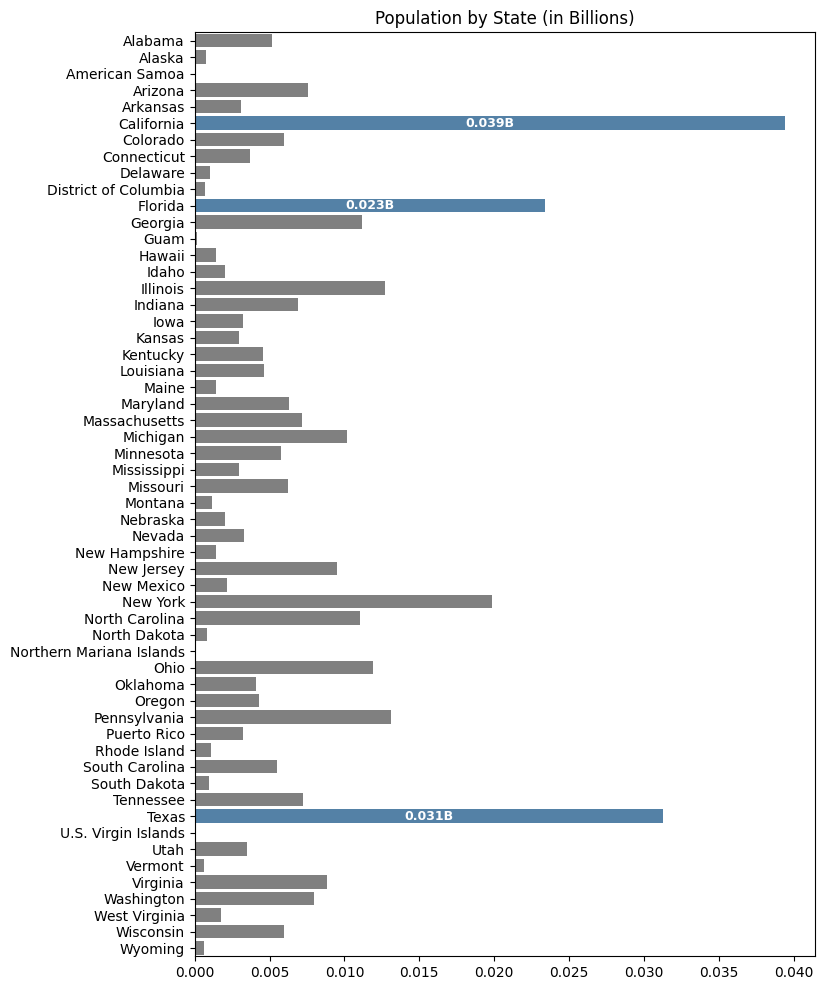

In [13]:
plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(analysis_df['population'], 95)

# Add a column to indicate top 5%
analysis_df['top5pct'] = analysis_df['population'] >= threshold

# Use hue for coloring instead of palette alone
ax = sns.barplot(
    data=analysis_df,
    x='population',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(analysis_df['population'], analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.3f}B",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Population by State (in Billions)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Funding Allocation by State

The Top 5% within the U.S. states and territories receving funding allocation are **California** ($18.4B), **Texas** ($14.2B), and **New York** ($10.1B). 

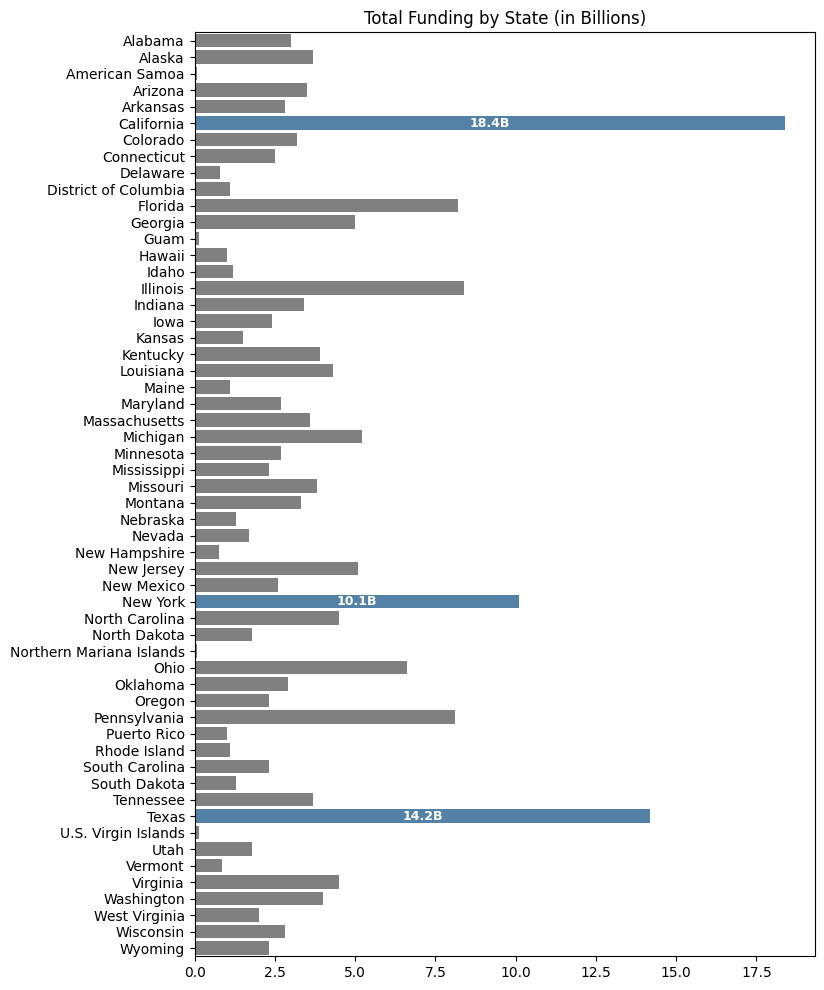

In [14]:
plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(analysis_df['total_funding'], 95)

# Add a column to indicate top 5%
analysis_df['top5pct'] = analysis_df['total_funding'] >= threshold

ax = sns.barplot(
    data=analysis_df,
    x='total_funding',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(analysis_df['total_funding'], analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.1f}B",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Total Funding by State (in Billions)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?

We will calculate the funding ratio of dollars spent per person within a state. The formula

> $funding\_ratio = total\_funding / population$ 

where total_funding and population is based by its respective state/territory. 

In [15]:
analysis_df['funding_ratio'] = analysis_df['total_funding'] /analysis_df['population']

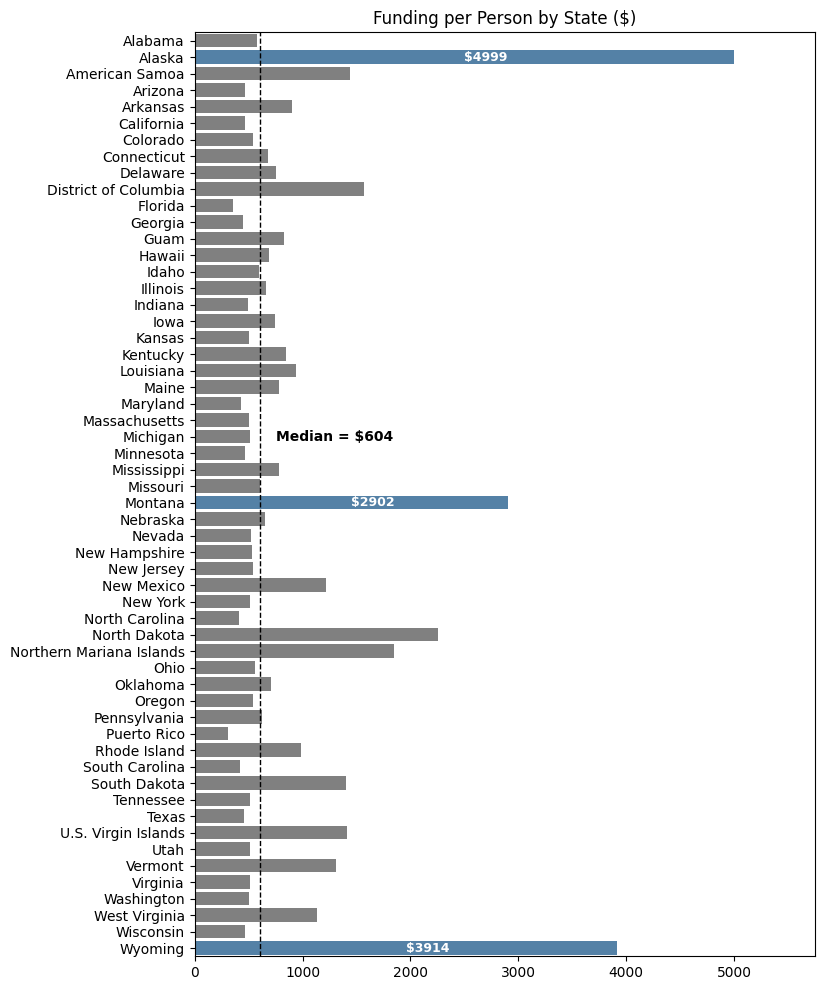

In [16]:
plt.figure(figsize=(8, 12))

# Compute 95th percentile
top5pct_threshold = analysis_df["funding_ratio"].quantile(0.95)

# Identify states in the top 5%
top5pct_states = analysis_df[analysis_df["funding_ratio"] >= top5pct_threshold]["state"]

ax = sns.barplot(
    data=analysis_df,
    x="funding_ratio",
    y="state",
    hue=analysis_df["state"].isin(top5pct_states),
    dodge=False,
    palette={True: "steelblue", False: "gray"},
    legend=False
)

# Annotate top 5% states
for i, (value, state) in enumerate(zip(analysis_df["funding_ratio"], analysis_df["state"])):
    if state in top5pct_states.values:
        ax.text(
            value * 0.5,
            i,
            f"${round(value)}",
            va="center",
            ha="left",
            fontsize=9,
            color="white",
            fontweight='bold'
        )

# Adjust x-axis
max_val = analysis_df["funding_ratio"].max()
ax.set_xlim(0, max_val * 1.15)

# Median line
median_val = analysis_df["funding_ratio"].median()
ax.axvline(median_val, color="black", linestyle="--", linewidth=1)

ax.text(
    median_val + 0.03 * max_val,
    24,
    f"Median = ${round(median_val)}",
    ha="left",
    va="center",
    fontsize=10,
    color="black",
    fontweight="bold",
    backgroundcolor="white"
)

# Plot Features
plt.title("Funding per Person by State ($)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

Another way to examine this is by comparing the proportion of a state's population to the proportion of funding it receives. This shows how much larger or smaller a state's funding is relative to its size. Values close to 1 indicate funding roughly proportional to population, while values significantly greater than 1 suggest the state is receiving disproportionately high funding, marking it as an outlier or exception.

When we do this, we can see that **Alaska** (9×), **Wyoming** (7×), and **Montana** (5×) receive funding that is significantly disproportionate relative to their populations.

In [17]:
analysis_df['funding_prop'] = analysis_df['total_funding'] / analysis_df['total_funding'].sum()
analysis_df['population_prop'] = analysis_df['population'] / analysis_df['population'].sum()
analysis_df['funding_to_pop_ratio'] = analysis_df['funding_prop'] / analysis_df['population_prop']

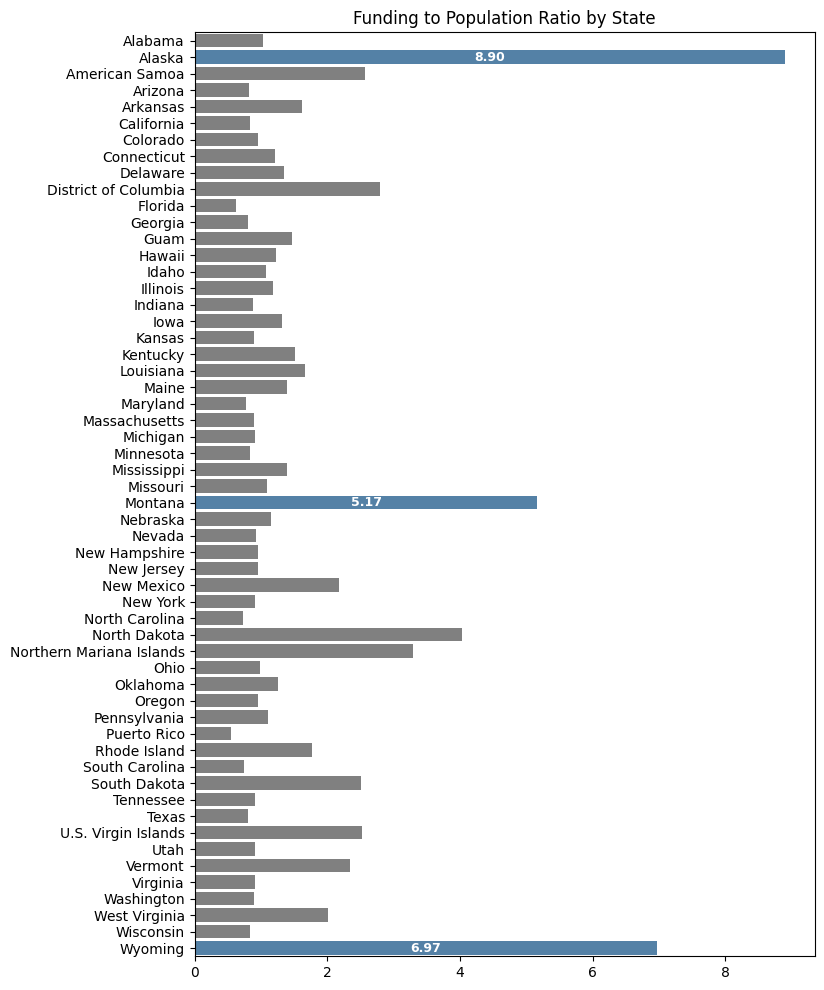

In [18]:
plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(analysis_df['funding_to_pop_ratio'], 95)

# Add a column to indicate top 5%
analysis_df['top5pct'] = analysis_df['funding_to_pop_ratio'] >= threshold

# Use hue for coloring instead of palette alone
ax = sns.barplot(
    data=analysis_df,
    x='funding_to_pop_ratio',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(analysis_df['funding_to_pop_ratio'], analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.2f}",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Funding to Population Ratio by State")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Does the allocation favor the political interests of the Biden administration?

Prior to running our data, we need to remove U.S. territories that does not provide us voting counts.

**Why?** [Link](https://www.usatoday.com/story/news/politics/elections/2024/11/05/can-us-territories-vote-for-president/76072641007/)
 > This is because while residents of American Samoa, Guam, the Northern Mariana Islands, Puerto Rico, and the U.S. Virgin Islands are U.S. citizens (except American Samoans, who are U.S. nationals),  they do not have voting representation in the Electoral College and therefore cannot vote for president in the general election.

In [19]:
analysis_df[analysis_df['votes_dem'].isna() | analysis_df['votes_gop'].isna()][['state', 'votes_gop', 'votes_dem']]

,state,votes_gop,votes_dem
2,American Samoa,NaN,NaN
12,Guam,NaN,NaN
37,Northern Mariana Islands,NaN,NaN
42,Puerto Rico,NaN,NaN
48,U.S. Virgin Islands,NaN,NaN


We find that the **District of Columbia** (17×), **Vermont** (2.2×), and **Massachusetts** (2×) tend to vote more for Democrats than Republicans, indicating a strong Democratic preference relative to other states.

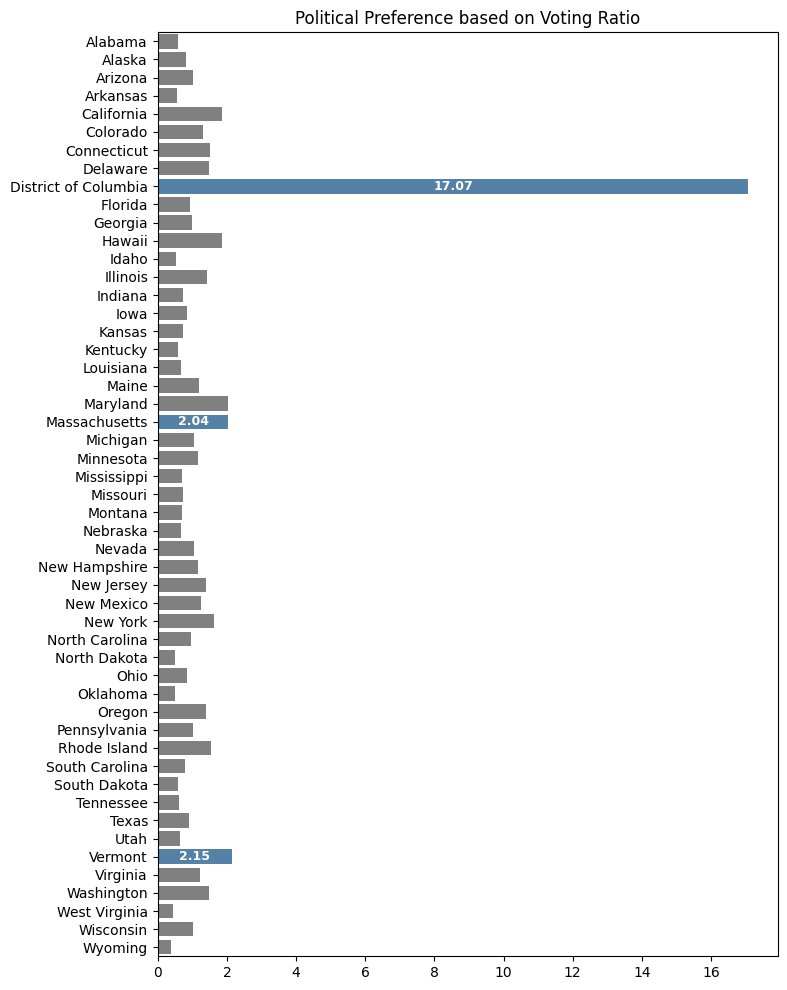

In [20]:
voting_analysis_df = analysis_df.copy()
voting_analysis_df = voting_analysis_df.dropna(subset=['votes_gop', 'votes_dem'])
voting_analysis_df['political_ratio'] = voting_analysis_df['votes_dem'] / voting_analysis_df['votes_gop']

plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(voting_analysis_df['political_ratio'], 95)

# Add a column to indicate top 5%
voting_analysis_df['top5pct'] = voting_analysis_df['political_ratio'] >= threshold

# Use hue for coloring instead of palette alone
ax = sns.barplot(
    data=voting_analysis_df,
    x='political_ratio',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(voting_analysis_df['political_ratio'], voting_analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.2f}",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Political Preference based on Voting Ratio")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

Using the information of which way a state/terriotry leans, we will categorize each state and determine the overall funding split amongst the party lines.

In [21]:
def assign_politcal_party(x):
    if x > 1:
        return "Democrat"
    elif x == 1:
        return "Split"
    elif x < 1:
        return "Republican"
    else:
        return "N/A"

voting_analysis_df['political_party'] = voting_analysis_df['political_ratio'].apply(assign_politcal_party)

In [22]:
funding_party_df = voting_analysis_df.groupby('political_party')['total_funding'].sum().reset_index()

We find that overall, total funding is aligned with democratic leaning states that would make us believe that it does indeed support Biden's administraion. 

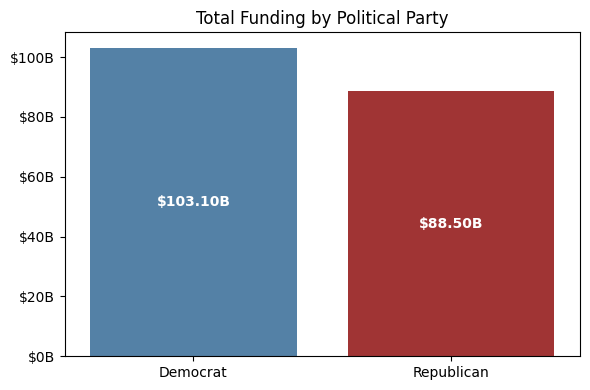

In [23]:
import matplotlib.ticker as mtick

party_colors = {
    "Democrat": "steelblue",
    "Republican": "firebrick"
}

plt.figure(figsize=(6, 4))

ax = sns.barplot(
    data=funding_party_df,
    x="political_party",
    y="total_funding",
    hue="political_party",
    palette=party_colors,
    legend=False
)

# Annotate each bar
for p in ax.patches:
    ax.annotate(
        f"${p.get_height():.2f}B",                      # format with $ and billions
        (p.get_x() + p.get_width() / 2, p.get_height() / 2),  # center of bar
        ha="center", va="center",
        color="white", fontsize=10, fontweight="bold"
    )

# Format y-axis as billions with $
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}B'))

plt.title("Total Funding by Political Party")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()


However, when we incorporate our earlier chart on funding per person by state, the disparity in funding becomes immediately apparent. The top four states receive significantly more funding, with a Democratic-leaning territory, the District of Columbia, ranking 4th. Even in 4th place, its funding ratio is closer to the median compared to Alaska.

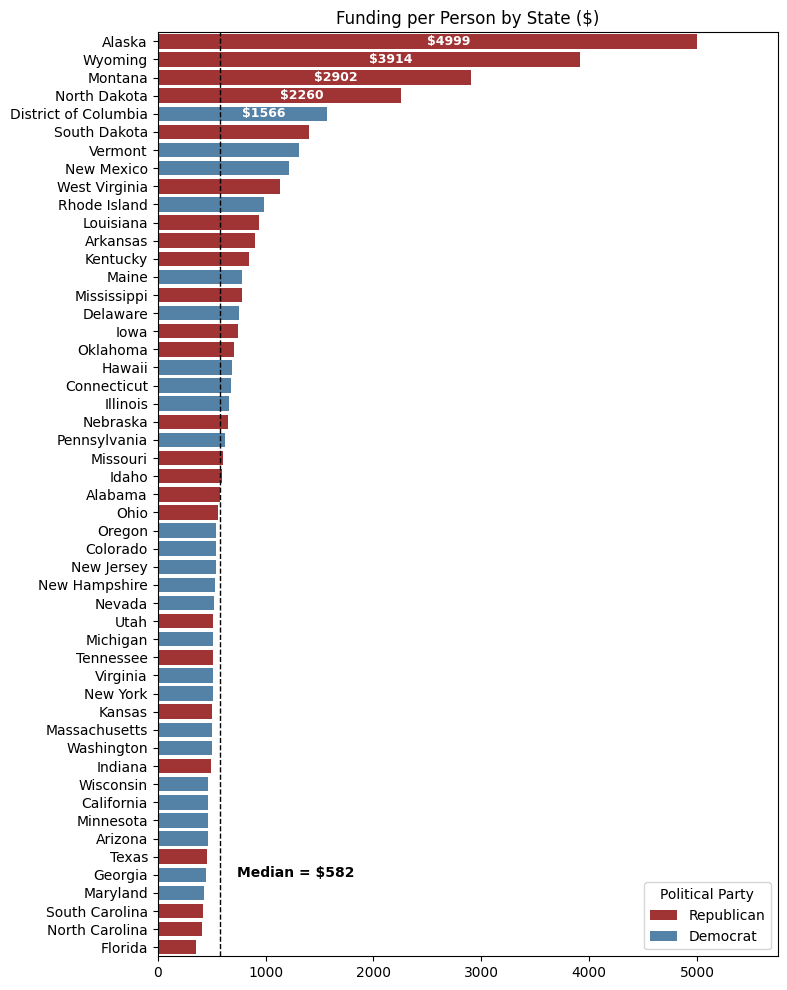

In [24]:
plt.figure(figsize=(8, 12))

# Sort by funding_ratio (descending)
plot_df = voting_analysis_df.sort_values("funding_ratio", ascending=False)

# Identify top 5 states
top5_states = plot_df.head(5)["state"]

# Barplot
ax = sns.barplot(
    data=plot_df,
    x="funding_ratio",
    y="state",
    hue="political_party",
    dodge=False,
    palette=party_colors,
    legend=True
)

# Annotate only top 5 states
for i, (value, state) in enumerate(zip(
    plot_df["funding_ratio"], 
    plot_df["state"]
)):
    if state in top5_states.values:
        ax.text(
            value * 0.5,   # center inside bar
            i,
            f"${round(value)}",
            va="center", ha="left",
            fontsize=9,
            color="white", fontweight="bold"
        )

# Adjust x-axis
max_val = plot_df["funding_ratio"].max()
ax.set_xlim(0, max_val * 1.15)

# Median line
median_val = plot_df["funding_ratio"].median()
ax.axvline(median_val, color="black", linestyle="--", linewidth=1)

# Median annotation
ax.text(
    median_val + 0.03 * max_val,
    len(plot_df) * 0.9,   # position near top dynamically
    f"Median = ${round(median_val)}",
    ha="left", va="center",
    fontsize=10,
    color="black", fontweight="bold",
    backgroundcolor="white"
)

# Plot Features
plt.title("Funding per Person by State ($)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.legend(title="Political Party")
plt.show()
